# CE-40719: Deep Learning
## HW3 - CNN / CNN Case Studies / CNN Applications
**(19 points)**
### Deadline: 

#### Name: Sadroddin Barikbin
#### Student No.: 98208824

In [43]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [44]:
%cd "drive/My Drive/HW3_part4"


[Errno 2] No such file or directory: 'drive/My Drive/HW3_part4'
/content/drive/My Drive/HW3_part4


In this assignment we go through the following topics:
- Making a Data set class that inherits from `torch.utils.data.Dataset`
- Transfer Learning or Fine Tuning
- Making a function for training

We are going to implement an instance segmentation model for Pedestrian Dataset containing 170 images with 345 instances of pedestrians. We will use a pre-trained [Mask R-CNN](https://arxiv.org/abs/1703.06870) model.

## 1. Setup 
First, we need to install `pycocotools`. This library will be used for computing the evaluation metrics following the COCO metric for intersection over union.
- For linux based Operating Systems or google colab run cell below:

In [0]:
%%shell

git clone https://github.com/cocodataset/cocoapi.git
cd cocoapi/PythonAPI
python setup.py build_ext install

- For Windows, run this command in Prompt:
`pip install git+https://github.com/philferriere/cocoapi.git#subdirectory=PythonAPI`

### Import Libraries:

In [0]:
from PIL import Image
import os
import numpy as np
import torch
import torch.utils.data

from engine import evaluate
import utils
import transforms as tm

import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

import math
import sys

## 2. Dataset class ( 8 points)
First, let's have a look at the dataset and how it is layed down.

The data is structured as follows
```
PedestrianDataset/
  PedMasks/
    FudanPed00001_mask.png
    FudanPed00002_mask.png
    FudanPed00003_mask.png
    FudanPed00004_mask.png
    ...
  PNGImages/
    FudanPed00001.png
    FudanPed00002.png
    FudanPed00003.png
    FudanPed00004.png
```

Here is one example of an image in the dataset, with its corresponding instance segmentation mask

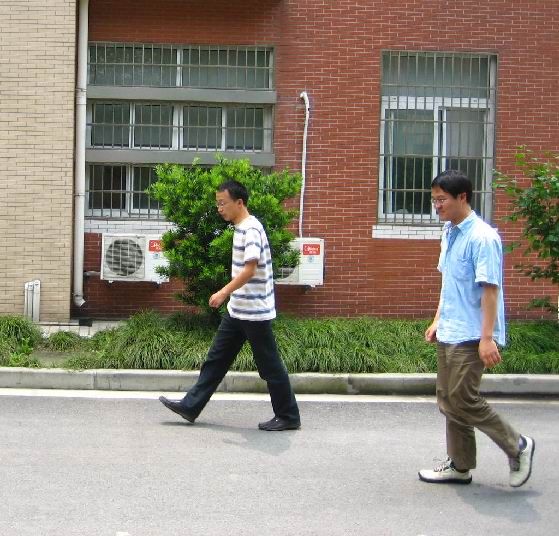

In [0]:
Image.open('PedestrianDataset/PNGImages/FudanPed00001.png')

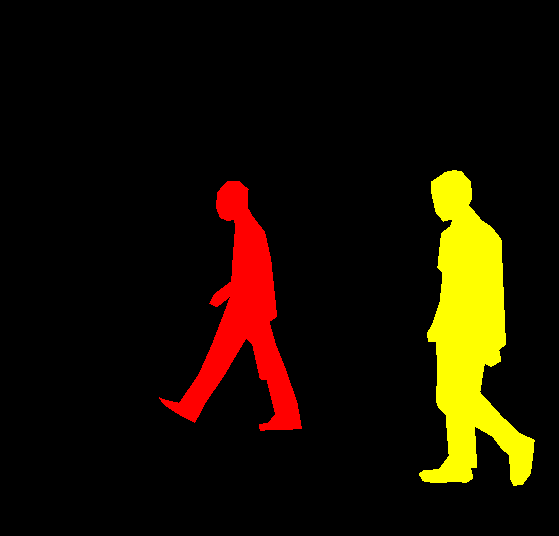

In [0]:
mask = Image.open('PedestrianDataset/PedMasks/FudanPed00001_mask.png')
# each mask instance has a different color, from zero to N, where
# N is the number of instances. In order to make visualization easier,
# let's adda color palette to the mask.
mask.putpalette([
    0, 0, 0, # black background
    255, 0, 0, # index 1 is red
    255, 255, 0, # index 2 is yellow
    255, 153, 0, # index 3 is orange
])
mask

So each image has a corresponding segmentation mask, where each color correspond to a different instance.

### Writting Dataset class code:
The dataset class should inherit from the standard `torch.utils.data.Dataset` class, and implement `__len__` and `__getitem__`.

The only specificity that we require is that the dataset `__getitem__` should return:

* image: a PIL Image of size (H, W)
* target: a dict containing the following fields
    * `boxes` (`FloatTensor[N, 4]`): the coordinates of the `N` bounding boxes in `[x0, y0, x1, y1]` format, ranging from `0` to `W` and `0` to `H`
    * `labels` (`Int64Tensor[N]`): the label for each bounding box
    * `image_id` (`Int64Tensor[1]`): an image identifier. It should be unique between all the images in the dataset, and is used during evaluation
    * `area` (`Tensor[N]`): The area of the bounding box. This is used during evaluation with the COCO metric, to separate the metric scores between small, medium and large boxes.
    * `iscrowd` (`UInt8Tensor[N]`): instances with `iscrowd=True` will be ignored during evaluation.
    * (optionally) `masks` (`UInt8Tensor[N, H, W]`): The segmentation masks for each one of the objects
    * (optionally) `keypoints` (`FloatTensor[N, K, 3]`): For each one of the `N` objects, it contains the `K` keypoints in `[x, y, visibility]` format, defining the object. `visibility=0` means that the keypoint is not visible. Note that for data augmentation, the notion of flipping a keypoint is dependent on the data representation, and you should probably adapt `transforms.py` for your new keypoint representation

your model returns the above methods, so they will make it work for both training and evaluation, and will use the evaluation scripts from pycocotools.

By default, the dataset should returns a `PIL.Image` and a dictionary
containing several fields, including `boxes`, `labels` and `masks`.

In [0]:
class PedDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        #####################################################################################
        #                          COMPLETE THE FOLLOWING SECTION                           #
        #####################################################################################
        # load all image files in "PNGImages" folder and "PedMasks" folder in self.imgs 
        # and self.masks respectively, using "os" library commands (like: os.listdir, os.path.join)
        # Note that sort them to ensure that they are aligned
        ##################################################################################### 
        self.imgs = sorted(os.listdir(os.path.join(root,"PNGImages")))
        self.masks = sorted(os.listdir(os.path.join(root,"PedMasks")))
        
        ####################################################################################
        #                                   THE END                                        #
        ####################################################################################        

    def __getitem__(self, idx):
        # load images ad masks
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        

        #####################################################################################
        #                          COMPLETE THE FOLLOWING SECTION                           #
        #####################################################################################
        # using Image loaded from PIL, save images in image_path and convert it to RGB
        # using Image loaded from PIL, save masks in mask_path and convert it to numpy array
        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        # instances in mask are encoded as different colors, so use np.unique to save unique
        # masks in obj_ids. Note that first id is the background, so remove it.
        #####################################################################################  
        img = Image.open(img_path)
        mask = np.array(Image.open(mask_path))


        obj_ids = sorted(np.unique(mask))[1:]

        ####################################################################################
        #                                   THE END                                        #
        ####################################################################################

        # split the color-encoded mask into a set
        # of binary masks
        masks = []
        for id in obj_ids:
          masks+=[mask==id]

        
        #####################################################################################
        #                          COMPLETE THE FOLLOWING SECTION                           #
        #####################################################################################
        # Get bounding box coordinates for each mask using for loop. Find xmin, xmax, ymin, ymax
        # and append all of them as list to boxes.
        # Then save boxes list as a tensor, set data type to float32.
        # Use torch.ones to save labels in appropriate shape.
        # Save masks as tensor, set data type to uint8.
        # save idx as a tensor in image_id
        # Compute area using boxes,save it as a Tuple.
        ##################################################################################### 
        num_objs = len(obj_ids)
        boxes = []
        areas=[]
        for i in range(num_objs):
            m=masks[i]
            for y in range(m.shape[0]):
              if np.any(m[y]):
                ymin=y
                break
            for y in reversed(range(m.shape[0])):
              if np.any(m[y]):
                ymax=y
                break
            for x in range(m.shape[1]):
              if np.any(m[:,x]):
                xmin=x
                break
            for x in reversed(range(m.shape[1])):
              if np.any(m[:,x]):
                xmax=x
                break
            boxes+=[[xmin,ymin,xmax,ymax]]
            areas+=[(ymax-ymin)*(xmax-xmin)]

        boxes = torch.tensor(boxes,dtype=torch.float32)
        
        labels = torch.ones(num_objs,dtype=torch.int64)
        masks = torch.tensor(masks,dtype=torch.uint8)

        image_id = torch.tensor(idx)
        area = torch.tensor(areas)
        ####################################################################################
        #                                   THE END                                        #
        ####################################################################################
        
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)
        
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

Let's see how the outputs are structured for this dataset (excpected Output included).

In [60]:
dataset = PedDataset('PedestrianDataset/')
dataset[32]

(<PIL.PngImagePlugin.PngImageFile image mode=RGB size=396x357 at 0x7F78C46106D8>,
 {'area': tensor([40727]),
  'boxes': tensor([[164.,  52., 303., 345.]]),
  'image_id': tensor(32),
  'iscrowd': tensor([0]),
  'labels': tensor([1]),
  'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8)})

## 3. Defining model and Prediction ( 11 points)

In this tutorial, we will be using [Mask R-CNN](https://arxiv.org/abs/1703.06870), which is based on top of [Faster R-CNN](https://arxiv.org/abs/1506.01497). Faster R-CNN is a model that predicts both bounding boxes and class scores for potential objects in the image.

![Faster R-CNN](FasterRCNN.jpg)

Mask R-CNN adds an extra branch into Faster R-CNN, which also predicts segmentation masks for each instance.

![Mask R-CNN](MaskRCNN.png)

One of popular way to modify models in torchvision modelzoo when we want to use a pre-trained model, and just finetune the last layer is transfer learning. In our task we want to also compute the instance segmentation masks, so we will be using Mask R-CNN.

Let's write some helper functions for data augmentation / transformation:

In [0]:
def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(tm.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(tm.RandomHorizontalFlip(0.5))
    return tm.Compose(transforms)

Note that we do not need to add a mean/std normalization nor image rescaling in the data transforms, as those are handled internally by the Mask R-CNN model.
### Training and evaluation:


In [0]:
# use our dataset and defined transformations
dataset = PedDataset('PedestrianDataset/', get_transform(train=True))
dataset_test = PedDataset('PedestrianDataset/', get_transform(train=False))

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders
numWorkers = 4 # in some cases you may change it to 0

#####################################################################################
#                          COMPLETE THE FOLLOWING SECTION                           #
#####################################################################################
# use torch.utils.data.DataLoader to make data loder for train and test
# for train set batch size to 2, shuffle True
# for test set batch size to 1, shuffle False
# for both of them set num workers to numWorkers, and set collate_fn to utils.collate_fn
##################################################################################### 
data_loader = torch.utils.data.DataLoader(dataset, batch_size=2,shuffle=True,num_workers=numWorkers,collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(dataset_test,batch_size=1,num_workers=numWorkers,collate_fn=utils.collate_fn)

####################################################################################
#                                   THE END                                        #
####################################################################################

Now let's instantiate the model and the optimizer

In [0]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2


# Model:

#####################################################################################
#                          COMPLETE THE FOLLOWING SECTION                           #
#####################################################################################
# load an instance segmentation model (maskrcnn_resnet50_fpn) pre-trained on COCO
# get the number of input features for the classifier
# replace the pre-trained head for box predictor with a new one
# now get the number of input features for the mask classifier
# and replace the mask predictor with a new one with hidden layer size equal to 256
# move model to the right device
##################################################################################### 
model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
model.roi_heads.box_predictor=FastRCNNPredictor(1024,num_classes)
model.roi_heads.mask_predictor=MaskRCNNPredictor(256,256,num_classes)
model.to(device)

#####################################################################################
#                                   THE END                                         #
#####################################################################################


#####################################################################################
#                          COMPLETE THE FOLLOWING SECTION                           #
#####################################################################################
# construct an SGD optimizer. set proper lr, momentum, and weight decay.
# construct a learning rate scheduler which decreases the learning rate by 10x every 3 epochs
#####################################################################################
optimizer = torch.optim.SGD(model.parameters(),lr=0.05,weight_decay=0.1)

lr_scheduler = torch.optim.lr_scheduler.MultiplicativeLR(optimizer,lambda epoch:0.1 if epoch%3==0 else 1)
#####################################################################################
#                                   THE END                                         #
#####################################################################################

Now, let's make a function for training each epoch:

In [0]:
def train(model, optimizer, data_loader, device, epoch, print_freq):
    model.train()
    metric_logger = utils.MetricLogger(delimiter="  ")
    metric_logger.add_meter('lr', utils.SmoothedValue(window_size=1, fmt='{value:.6f}'))
    header = 'Epoch: [{}]'.format(epoch)

    lr_scheduler = None
    if epoch == 0:
        warmup_factor = 1. / 1000
        warmup_iters = min(1000, len(data_loader) - 1)

        lr_scheduler = utils.warmup_lr_scheduler(optimizer, warmup_iters, warmup_factor)

    for images, targets in metric_logger.log_every(data_loader, print_freq, header):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        
        #####################################################################################
        #                          COMPLETE THE FOLLOWING SECTION                           #
        #####################################################################################
        # save all losses as dict in loss_dict
        # compute sum of all losses and save it in lossess
        #####################################################################################        
        loss_dict = model(images,targets)

        losses = sum([loss_dict[key] for key in loss_dict])
        #####################################################################################
        #                                   THE END                                         #
        #####################################################################################
        
        # reduce losses over all GPUs for logging purposes
        loss_dict_reduced = utils.reduce_dict(loss_dict)
        losses_reduced = sum(loss for loss in loss_dict_reduced.values())
        loss_value = losses_reduced.item()
        
        #####################################################################################
        #                          COMPLETE THE FOLLOWING SECTION                           #
        #####################################################################################
        # print loss_value and loss_dict_reduced, if loss_value is not finite and stop the 
        # training using sys library.
        # clear old gradients from the last step.
        # compute the derivative of the losses 
        # make the optimizer to take a step based on the gradients of the parameters.
        #####################################################################################
        if np.isnan(loss_value):
          print(loss_value,loss_dict_reduced)
          sys.exit()
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()  

        #####################################################################################
        #                                   THE END                                         #
        #####################################################################################
        
        if lr_scheduler is not None:
            lr_scheduler.step()

        metric_logger.update(loss=losses_reduced, **loss_dict_reduced)
        metric_logger.update(lr=optimizer.param_groups[0]["lr"])


And now let's train the model for 10 epochs, evaluating at the end of every epoch.

In [89]:
# let's train it for 10 epochs
num_epochs = 10

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    #evaluate(model, data_loader_test, device=device)

Epoch: [0]  [ 0/60]  eta: 0:01:59  lr: 0.000897  loss: 3.3057 (3.3057)  loss_classifier: 0.9454 (0.9454)  loss_box_reg: 0.2746 (0.2746)  loss_mask: 2.0652 (2.0652)  loss_objectness: 0.0134 (0.0134)  loss_rpn_box_reg: 0.0071 (0.0071)  time: 1.9852  data: 1.4317  max mem: 14247
Epoch: [0]  [10/60]  eta: 0:00:29  lr: 0.009363  loss: 0.8185 (1.4458)  loss_classifier: 0.2709 (0.4523)  loss_box_reg: 0.1694 (0.1970)  loss_mask: 0.3728 (0.7716)  loss_objectness: 0.0134 (0.0168)  loss_rpn_box_reg: 0.0059 (0.0082)  time: 0.5987  data: 0.1678  max mem: 14535
Epoch: [0]  [20/60]  eta: 0:00:21  lr: 0.017829  loss: 0.7526 (1.0875)  loss_classifier: 0.2101 (0.3117)  loss_box_reg: 0.1711 (0.2127)  loss_mask: 0.3070 (0.5376)  loss_objectness: 0.0104 (0.0138)  loss_rpn_box_reg: 0.0088 (0.0117)  time: 0.4712  data: 0.0415  max mem: 14700
Epoch: [0]  [30/60]  eta: 0:00:14  lr: 0.026295  loss: 0.5654 (0.8796)  loss_classifier: 0.0881 (0.2343)  loss_box_reg: 0.1446 (0.1851)  loss_mask: 0.2355 (0.4373)  loss

### Prediction:
Now that training has finished, let's have a look at what it actually predicts in a test image

In [0]:
# pick one image from the test set
img, _ = dataset_test[0]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])

Printing the prediction shows that we have a list of dictionaries. Each element of the list corresponds to a different image. As we have a single image, there is a single dictionary in the list.
The dictionary contains the predictions for the image we passed. In this case, we can see that it contains `boxes`, `labels`, `masks` and `scores` as fields.

In [95]:
torch.sum(prediction[0]['masks'],axis=0)

torch.Size([1, 411, 504])

Let's inspect the image and the predicted segmentation masks.

For that, we need to convert the image, which has been rescaled to 0-1 and had the channels flipped so that we have it in `[C, H, W]` format.

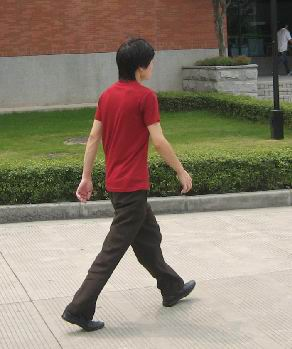

In [79]:
Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())

And let's now visualize the top predicted segmentation mask. The masks are predicted as `[N, 1, H, W]`, where `N` is the number of predictions, and are probability maps between 0-1.

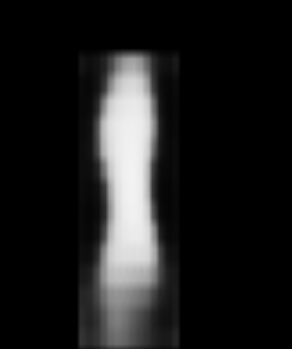

In [91]:
Image.fromarray(prediction[0]['masks'][0, 0].mul(255).byte().cpu().numpy())

for some other examples visualize original image and all predicted segmentation masks.

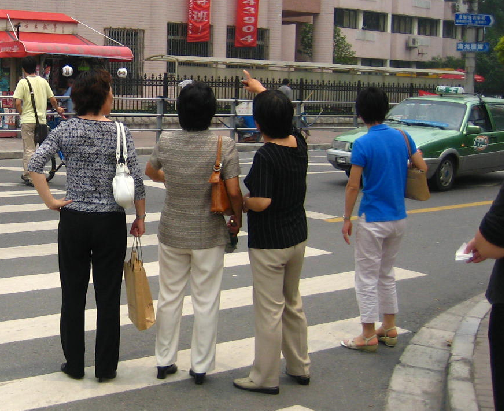

In [92]:
img, _ = dataset_test[10]
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])
Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())

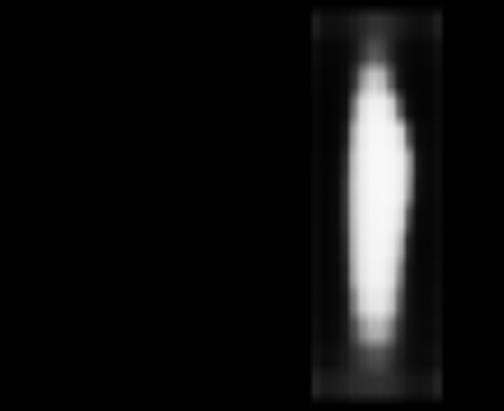

In [102]:
Image.fromarray(prediction[0]['masks'][5, 0].mul(255).byte().cpu().numpy())